<p style="text-align:center;font-size:200%;"><b>Comparing Object Detection algorithms</b></p>
<p style="text-align:center;font-size:150%;"><b>on vehicles at motorway speed in the UK</b></p>


In [1]:
import pandas as pd
import os,sys
import torch
from tqdm.notebook import trange
import PIL
from torchvision import transforms
from torch.autograd import Variable
from skimage import io
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
Tensor = torch.cuda.FloatTensor

# Introduction

Object detection performance varies with degrees of precision and accuracy across different spectrum of conditions such as lighting, weather, hardware limitations and more (Sivaraman & Trivedi, 2013). Object detection will always be at the forefront on testing and experimentation due to the possibility of maintaining driver awareness that can cause accidents and deaths (Dhamanam et al., 2019). It is important to test the robustness of a detector as we are introduced more object detection methods now and in the future. 
We used three pre-trained object detection algorithms as follows:<br>
* <a href="https://github.com/eriklindernoren/PyTorch-YOLOv3">YOLOV3:</a> An implemention of "Yolov3: An incremental improvement" paper by (Redmon and Farhadi 2018)
* <a href="https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-your-model">Faster R-CNN:</a> Based on the paper of "Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks" (Ren et al. 2015) 
* <p style="color:red;">SSD-VGG16:</p>

In this Notebook we first will explain how data is collected and prepared. In section 3 the models will be introduced and examined on the dataset. The results will be discussed in section 4. Afterward, we would apply ***** as the best performance algorithm  to a live run.

# data preparation

## data collection

something about how data has been collected ( Brandon please write something here )

## Annotation data

After collecting footages, we used <a href="https://github.com/alexandre01/UltimateLabeling">UltimateLabeling</a> to annotate the videos. This tool not only extracts frames from videos easily, but also it has been equipped with some handy tools for annotation. The output is a csv file in the format: "class_id", "xc", "yc", "w", "h"<br> After annotation, all the output csv files have been merged in a single file to start inference with the networks.Data is accessible <a href="https://livebournemouthac-my.sharepoint.com/:f:/g/personal/s5220221_bournemouth_ac_uk/En-25u9q7SJDvBzjFPJLomkBNfHtgB53zJsT2Ci5nWFLGQ?e=SVpRvx">here</a>. We used this <a href="https://livebournemouthac-my.sharepoint.com/:u:/g/personal/s5220221_bournemouth_ac_uk/ERlnKd89qqNJlj_7ajNfLiUB2aUCK9IaPefKO3r-9i2Tmg?e=gcqeeg">notebook</a> to merge all the csv file into a single file. YOLOV3 and FAST-RCNN had pretrained weights on MSCOCO dataset and SSD-VGG16 on VOC datasets. So we had to reduce our classes in annotation process from 5 classes (car, van, truck, bus and motorcycle) to 4 classes(van removed) to match with COCO classes and to three classes (car, bus and motorcycle) to match with VOC dataset.


# Models

We used the same annotation list both for YOLOV3 and FAST-RCNN.
Download the csv_file from <a href="https://livebournemouthac-my.sharepoint.com/:f:/g/personal/s5220221_bournemouth_ac_uk/En-25u9q7SJDvBzjFPJLomkBNfHtgB53zJsT2Ci5nWFLGQ?e=mywAwP">here.</a>

In [4]:
csv_file = 'mergedlbls.csv'
frames_list = pd.read_csv(csv_file)
frames_list.head()

,im_name,class_id,Xc,Yc,w,h
0,RainyDay2/00081.jpg,truck,1011,594,56,58
1,RainyDay2/00082.jpg,truck,1006,599,54,59
2,RainyDay2/00083.jpg,truck,1007,600,60,71
3,RainyDay2/00084.jpg,truck,1006,603,58,62
4,RainyDay2/00085.jpg,truck,1007,598,52,66


The distribution of the classes in the dataset is as follows:

In [5]:
cls_cnt = frames_list.iloc[:,1].value_counts()
class_total =cls_cnt.to_dict()
class_total

{'car': 6904, 'truck': 356, 'bus': 18, 'motorcycle': 14}

In [6]:
# To detect the width and height of the input image
def detect_image(img):
    # scale image
    ratio = min(inp_w/img.size[0], inp_h/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    
    
    return imh,imw

In [7]:
# to avoid 0/0
def division(n, d):
    return n / d if d else 0

## YOLOV3

We used YOLOV3 for our first object detection expreiment<p style="color:red;">introducing yolo</p>

In [11]:
#!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3.git

In [12]:
#os.chdir('PyTorch-YOLOv3')

In [13]:
import models as net
import utils as utls

### Parameters

To download the pre-trained weight from <a href="https://livebournemouthac-my.sharepoint.com/:u:/g/personal/s5220221_bournemouth_ac_uk/EZ1BAzbyq3tEkPNvdBxNFC0Bf68N0stRqNKjIcdmiXX0yg?e=6nRRJY">here</a> 

In [15]:
cfg_file = 'config/yolov3.cfg' # loading configuration file
weight_file = 'weights/yolov3.weights' # loadeing pre-trained weights
class_path = 'data/coco.names'
# input image size
inp_w = 416
inp_h = 416 
conf_thres=0.8 # to get the bounding boxes with confidence > 80%
nms_thres=0.4

### setting classes and class_Ids

Since we are goining to infenece with YOLO, we set COCO's classes names for our dataset

In [16]:
class_names = utls.utils.load_classes(class_path) # MSCOCO CLass names

c2i = {k:v for v,k in enumerate(class_names)}
targets= {'car':c2i['car'],'truck':c2i['truck'],'bus':c2i['bus'],'motorcycle':c2i['motorbike']} # object classes
i2c = lambda i : [k for k,v in targets.items() if v ==i]
targets

{'car': 2, 'truck': 7, 'bus': 5, 'motorcycle': 3}

### loading YOLO

In [27]:
torch.cuda.empty_cache()
model = net.Darknet(cfg_file,img_size=inp_w)
model.load_darknet_weights(weight_file)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [18]:
def YOLO_pred(img_idx):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    img = PIL.Image.open(img_path)
    
    imh,imw = detect_image(img)
    
    # https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)), # resize, pad and transform to tensor
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
     
    
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    with torch.no_grad():
        detections = model(input_img)
               
        detections  = utls.utils.non_max_suppression(detections, conf_thres, nms_thres)
        
    return detections
    

### Prediction

Download the dataset from <a href="https://livebournemouthac-my.sharepoint.com/:f:/g/personal/s5220221_bournemouth_ac_uk/En-25u9q7SJDvBzjFPJLomkBNfHtgB53zJsT2Ci5nWFLGQ?e=mywAwP">here</a> 

In [19]:
class_correct = {'car':0,'truck':0,'bus':0,'motorcycle':0} # to count number of correct detected classes

root_dir = '../Frames/'
correct = 0
detected = 0
not_detected = 0

for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    
    detections = YOLO_pred(image_idx)

    if detections[0] is not None:
        y_ =[]
        for i in range (len(detections[0])):
            y_.append(detections[0][i][6].numpy().tolist())

        if y in y_:
            class_correct[cls_name] +=1
            correct +=1
    else:
         not_detected+=1

print(f'Accuracy of the YOLOV3 on the {frames_list.shape[0]} test images: {100 * correct / frames_list.shape[0]:0.2f}%\n'
    
)

for k,v in class_correct.items():
    cls_acc = 100 * division(class_correct[k],class_total[k])
    print(f'Accuracy of {k}: {cls_acc:0.2f}%')

FileNotFoundError: [Errno 2] No such file or directory: '../Frames/RainyDay2/00081.jpg'

## FAST_RCNN

In [33]:
cd ..

C:\Users\ehsan\Documents\ComputerVision\ObjectDetection_Compare_BU


In [25]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

### Parametrs

For doing inference with FAST_RCNN we used a  <a href="https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/">pre-trained network</a> which had been tranied on a different version of COCO dataset. SO we had to define another COCO names.

In [21]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

i2c = lambda i : [k for k,v in targets.items() if v ==i]
c2i = {k:v for v,k in enumerate(COCO_INSTANCE_CATEGORY_NAMES)}

targets= {'car':c2i['car'],'truck':c2i['truck'],'bus':c2i['bus'],'motorcycle':c2i['motorcycle']} # object classes
targets

{'car': 3, 'truck': 8, 'bus': 6, 'motorcycle': 4}

In [22]:
# input image size
inp_w = 300
inp_h = 400

In [23]:
def FRCNN_pred(img_idx):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    img = PIL.Image.open(img_path)
    
    imh,imw = detect_image(img)
    
    # https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)), # resize, pad and transform to tensor
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
     
    
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    with torch.no_grad():
        detections = model(input_img)
        
    return detections
    

### Loading FAST_RCNN

In [26]:
# loading the model
torch.cuda.empty_cache()

model = fasterrcnn_resnet50_fpn(pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.eval()

model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\ehsan/.cache\torch\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

### Prdediction

In [12]:
class_correct = {'car':0,'truck':0,'bus':0,'motorcycle':0} # to count number of correct detected classes

root_dir = 'Frames/'
correct = 0
detected = 0
not_detected = 0
trsh = .6
for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    
    detections = FRCNN_pred(image_idx)
    
    if detections is not None:
                labels = detections[0]['labels'].cpu().tolist()
                scores = detections[0]['scores'].cpu().tolist()
                scores_ =[x for x in scores if x>trsh] # applying a threshold to the confidence scores
                
                if len(scores_)!=0:
                    scores_.sort()
                    mx_scores_idx =scores_.index(scores_[-1]) # finding the maximum score
                    
                    if mx_scores_idx !=0:
                        y_ = labels[:mx_scores_idx+1] # 
                else:
                    y_ =[]
                    
                if len(y_)!=0:    

                    if y in y_:
                        class_correct[cls_name] +=1
                        correct +=1

                else:
                     not_detected+=1

    

print(f'Accuracy of the FAST_RCNN on the {frames_list.shape[0]} test images: {100 * correct / frames_list.shape[0]:0.2f}%\n'
    
)

for k,v in class_correct.items():
    cls_acc = 100 * division(class_correct[k],class_total[k])
    print(f'Accuracy of {k}: {cls_acc:0.2f}%')


Accuracy of the FAST_RCNN on the 7292 test images: 21.52%

Accuracy of car: 21.61%
Accuracy of truck: 21.35%
Accuracy of bus: 5.56%
Accuracy of motorcycle: 0.00%


## SSD

For doing prediction with SSD we used this pretrained  <a href="https://github.com/qfgaohao/pytorch-ssd">SSD-vgg16</a>. This model has been trained on VOC dataset

In [34]:
!git clone "https://github.com/qfgaohao/pytorch-ssd.git"

Cloning into 'pytorch-ssd'...


In [35]:
os.chdir('pytorch-ssd')

In [36]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.utils.misc import Timer
import cv2

### Parameters

Since this model has been trained on VOC dataset and 'truck' is not a valid class in this dataset, we first had to remove 'truck' from our dataset.

In [37]:
csv_file = '../mergedlbls.csv'
frames_list = pd.read_csv(csv_file)
trucks = frames_list.loc[frames_list.class_id == 'truck']
truck_indexes = trucks.index
frames_list = frames_list.drop(index=truck_indexes)
frames_list.head()

,im_name,class_id,Xc,Yc,w,h
31,RainyDay2/00111.jpg,car,1141,613,55,36
32,RainyDay2/00112.jpg,car,1179,614,62,43
35,RainyDay2/00113.jpg,car,1233,612,72,51
36,RainyDay2/00114.jpg,car,1316,605,104,58
37,RainyDay2/00114.jpg,car,1122,606,56,42


The new dataset has 3 classes as follows:

In [38]:
cls_cnt = frames_list.iloc[:,1].value_counts()
class_total =cls_cnt.to_dict()
class_total

{'car': 6904, 'bus': 18, 'motorcycle': 14}

We matched the dataset classes and VOC classes as follows:

In [39]:
VOC_NAMES =['background','aeroplane','bicycle','bird','boat','bottle',
              'bus','car','cat','chair','cow','diningtable','dog','horse',
              'motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
c2i = {k:v for v,k in enumerate(VOC_NAMES)}
targets= {'car':c2i['car'],'bus':c2i['bus'],'motorcycle':c2i['motorbike']} # object classes
i2c = lambda i : [k for k,v in targets.items() if v ==i]
targets

{'car': 7, 'bus': 6, 'motorcycle': 14}

To download the weights for the pretrained model from <a href="https://storage.googleapis.com/models-hao/vgg16-ssd-mp-0_7726.pth">here</a>

In [41]:
model_path = 'vgg16-ssd-mp-0_7726.pth'

## loading model

In [43]:
torch.cuda.empty_cache()
net = create_vgg_ssd(len(VOC_NAMES), is_test=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.load(model_path)

net.eval()

net.to(device)


SSD(
  (base_net): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
predictor = create_vgg_ssd_predictor(net, candidate_size=200)

In [45]:
def SSD_pred(img_idx, trsh):
    
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    
    orig_image = cv2.imread(img_path)
    img = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    
    with torch.no_grad():
         bbox, classes, confidences = predictor.predict(img, 10, trsh)

    return bbox, classes, confidences
    

In [17]:
class_correct = {'car':0,'bus':0,'motorcycle':0} # to count number of correct detected classes

root_dir = 'Frames/'
correct = 0
detected = 0
not_detected = 0
trsh = .5
old_stdout = sys.stdout
for image_idx in trange(frames_list.shape[0]):

    cls_name = frames_list.iloc[image_idx,1] # class name
    y = targets[cls_name] # convert to intiger
    sys.stdout = open(os.devnull,'w')
    _,y_,confidences = SSD_pred(image_idx,trsh)

    if y_.size()[0] !=0:
        
        if y in y_:
            class_correct[cls_name] +=1
            correct +=1

    else:
         not_detected+=1
            
            
sys.stdout.close()
sys.stdout = old_stdout
print(f'Accuracy of the SSD on the {frames_list.shape[0]} test images: {100 * correct / frames_list.shape[0]:0.2f}%\n'
    
)

for k,v in class_correct.items():
    cls_acc = 100 * division(class_correct[k],class_total[k])
    print(f'Accuracy of {k}: {cls_acc:0.2f}%')


Accuracy of the FAST_RCNN on the 6936 test images: 21.90%

Accuracy of car: 22.00%
Accuracy of bus: 0.00%
Accuracy of motorcycle: 0.00%


# Discussion and Results

## Comparison table

## visual comparision

In [3]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

In [4]:
def draw_rect(ax, xy, w, h):
    patch = ax.add_patch(patches.Rectangle(xy, w, h, fill=False, edgecolor='yellow', lw=2))
    patch.set_path_effects([patheffects.Stroke(linewidth=3, foreground='black'), patheffects.Normal()])

In [12]:
root_dir = 'Frames/'
def bbox(img_idx):
    img_path = os.path.join(root_dir,frames_list.iloc[img_idx,0])
    x = io.imread(img_path)
    im = show_img(x, title=frames_list.iloc[img_idx,1])
    xc = frames_list.iloc[img_idx,2]
    yc = frames_list.iloc[img_idx,3]
    w = frames_list.iloc[img_idx,4]
    h = frames_list.iloc[img_idx,4]
    xtl = xc-w/2
    ytl = yc-w/2
    draw_rect(im, [xtl, ytl], w, h)

In [13]:
def bbox_inp(img_idx):
    cls_name = frames_list.iloc[img_idx,1]
    xc = frames_list.iloc[img_idx,2]
    yc = frames_list.iloc[img_idx,3]
    w = frames_list.iloc[img_idx,4]
    h = frames_list.iloc[img_idx,4]
    
    return(cls_name,xc,yc,w,h)

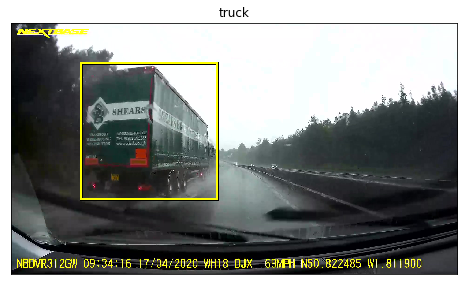

In [14]:
bbox(165)

# References

* Dhamanam, N., Kathirvelu, M. and Rao, T.G., 2019. Review of Environment Perception for Intelligent Vehicles. International Journal of Engineering and Management Research (IJEMR), 9(2), pp.13-17.
* Redmon, J. and Farhadi, A., 2018. Yolov3: An incremental improvement. arXiv preprint arXiv:1804.02767.
* Ren, S., He, K., Girshick, R., and Sun, J., 2015. Faster r-cnn: Towards real-time object detection with region proposal networks. In: . Presented at the Advances in neural information processing systems, 91–99.


* Sivaraman, S. and M. M. Trivedi (2013). A review of recent developments in vision-based vehicle detection. 2013 IEEE Intelligent Vehicles Symposium (IV), IEEE.


